In [1]:
# Red Wine Quality Prediction

## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set(style="whitegrid")

In [2]:
# Load the dataset
data = pd.read_csv('/Users/mikaelfahre/Desktop/Programmering/Codecademy Portefølje/Red Wine Quality/winequality-red.csv')

# Display the first few rows of the dataset
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


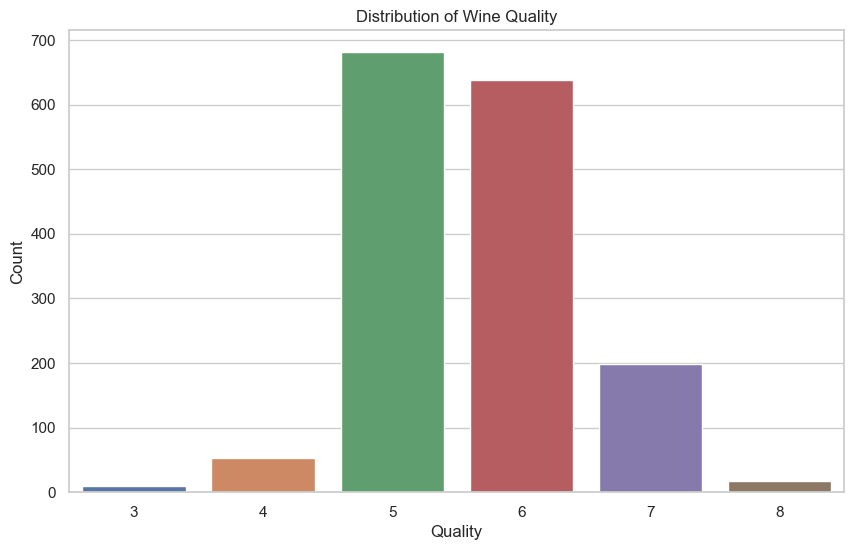

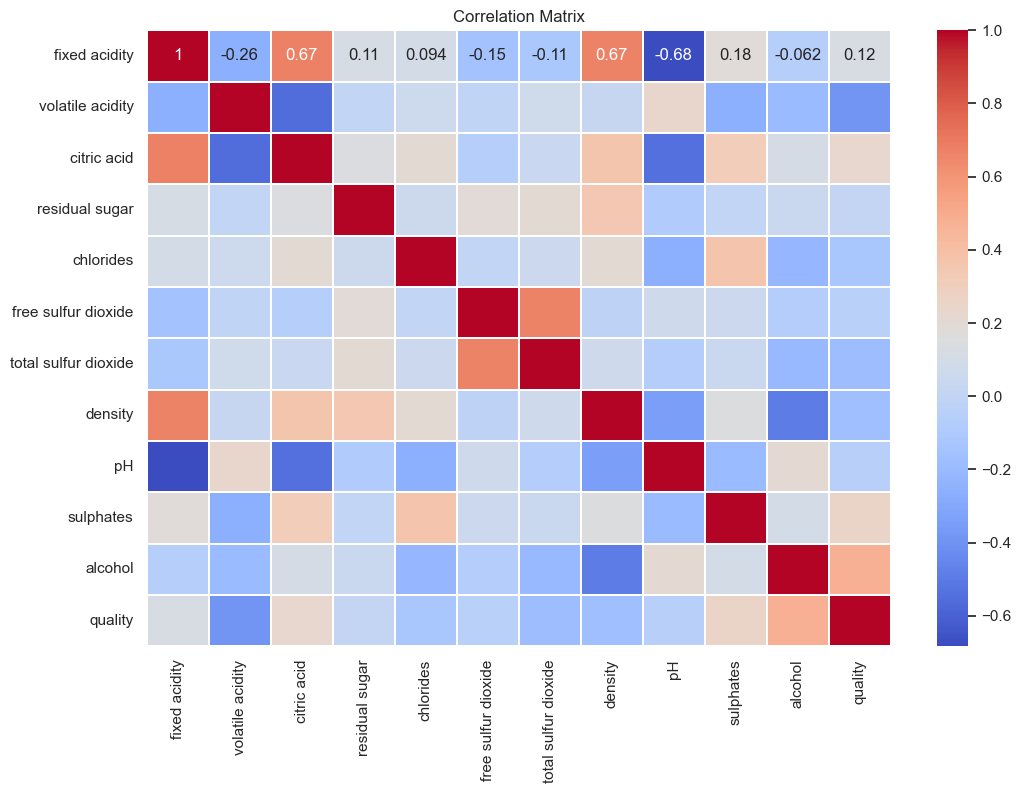

In [3]:
# Summary statistics
data.describe()

# Check for missing values
data.isnull().sum()

# Plot the distribution of wine quality
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=data)
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.2)
plt.title('Correlation Matrix')
plt.show()

In [4]:
# Convert quality into binary classification: good (1) and not good (0)
data['quality'] = data['quality'].apply(lambda x: 1 if x > 6.5 else 0)

# Split the data into features and target variable
X = data.drop('quality', axis=1)
y = data['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)


In [5]:
# Define a pipeline with PolynomialFeatures
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('classifier', GradientBoostingClassifier())
])
print("Pipeline defined")

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'poly__degree': [1, 2, 3],
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__max_depth': randint(3, 10),
    'classifier__min_samples_split': randint(2, 20)
}
print("Parameter grid defined")

# Define RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42)
print("Random search defined")

# Train the models
random_search.fit(X_train_balanced, y_train_balanced)
print("Model trained!")

# Best model
best_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")
print(f"Best ROC AUC score: {random_search.best_score_:.2f}")

Pipeline defined
Parameter grid defined
Random search defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model trained!
Best parameters: {'classifier__learning_rate': 0.3029844867497959, 'classifier__max_depth': 6, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 323, 'poly__degree': 1}
Best ROC AUC score: 0.99


              precision    recall  f1-score   support

           0       0.95      0.96      0.96       346
           1       0.73      0.70      0.72        54

    accuracy                           0.93       400
   macro avg       0.84      0.83      0.84       400
weighted avg       0.92      0.93      0.92       400

ROC AUC Score: 0.92


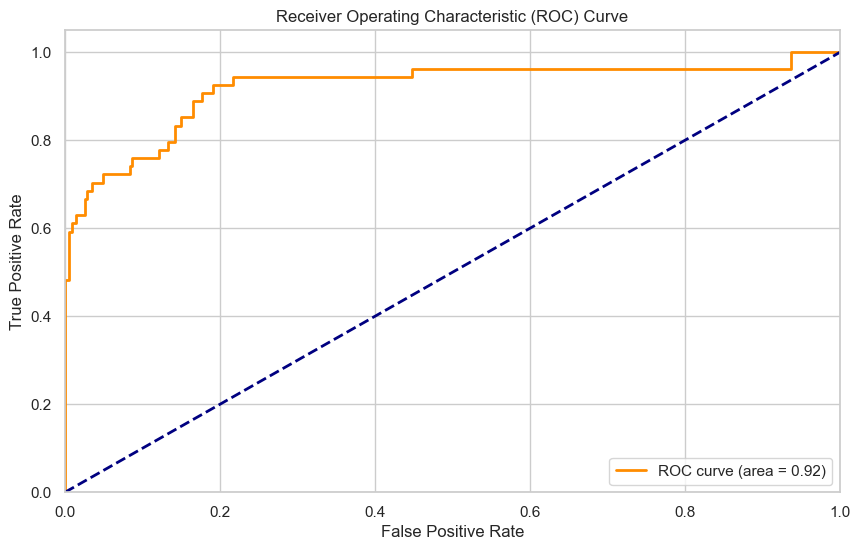

In [6]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       346
           1       0.69      0.69      0.69        54

    accuracy                           0.92       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.92      0.92      0.92       400

Stacking ROC AUC Score: 0.93


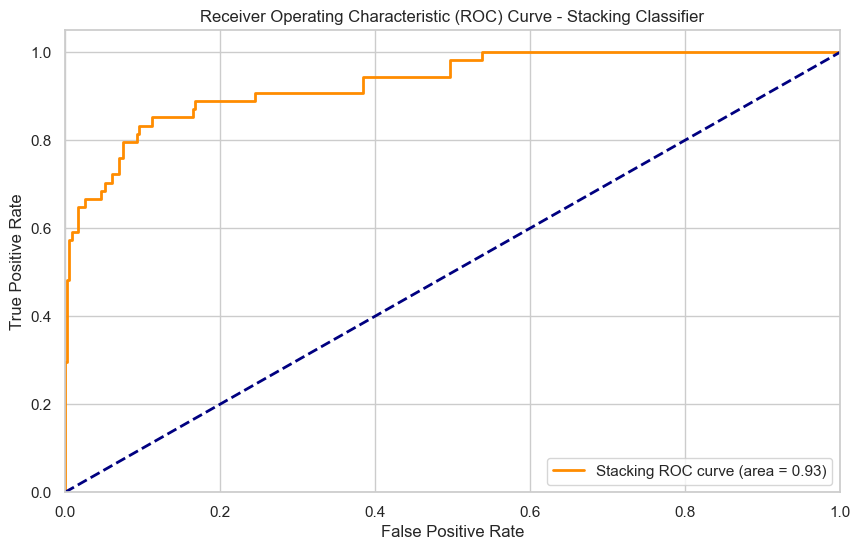

In [7]:
# Ensemble method - Stacking Classifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42))
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacking_clf.fit(X_train_balanced, y_train_balanced)

# Stacking model predictions
y_pred_stack = stacking_clf.predict(X_test)
y_pred_prob_stack = stacking_clf.predict_proba(X_test)[:, 1]

# Classification report for stacking model
print(classification_report(y_test, y_pred_stack))

# ROC-AUC score for stacking model
roc_auc_stack = roc_auc_score(y_test, y_pred_prob_stack)
print(f"Stacking ROC AUC Score: {roc_auc_stack:.2f}")

# Plot ROC curve for stacking model
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test, y_pred_prob_stack)
plt.figure(figsize=(10, 6))
plt.plot(fpr_stack, tpr_stack, color='darkorange', lw=2, label=f'Stacking ROC curve (area = {roc_auc_stack:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Stacking Classifier')
plt.legend(loc="lower right")
plt.show()